# Sarcasm Detector

In [1]:
!nvidia-smi

Fri Jan 19 14:20:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!pip install transformers

## Get and Load Data

In [3]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [4]:
# Load dependencies


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import transformers
import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


In [5]:
!gdown --id 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz
To: /content/SarcasmDetect.json
100% 6.06M/6.06M [00:00<00:00, 87.5MB/s]


In [6]:
# load and view dataset

df = pd.read_json('./SarcasmDetect.json', lines=True)
df.head()


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [7]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("TF Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
TF Hub version:  0.15.0
GPU is available


In [8]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 19 14:21:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Remove all records with no headline text

In [10]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 894.3+ KB


In [11]:
# check for data balance

percentage_by_category = df['is_sarcastic'].value_counts(normalize=True) * 100
percentage_by_category

0    52.36032
1    47.63968
Name: is_sarcastic, dtype: float64

In [12]:
# drop article_link feature to prevent leakage
to_drop = ['article_link']
df=df.drop(to_drop, axis=1)
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [13]:

headlines = df['headline'].values
sarcasms = df['is_sarcastic'].values

train_headlines = headlines[:20033]
test_headlines = headlines[20033:]


train_sarcasms = sarcasms[:20033]
test_sarcasms = sarcasms[20033:]

train_headlines.shape, test_headlines.shape

((20033,), (8586,))

In [14]:
# Prepare train and test datasets

#from sklearn.model_selection import train_test_split
#train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
#train_df.shape, test_df.shape

In [15]:
!sudo pip3 install contractions
!sudo pip3 install textsearch
!sudo pip3 install tqdm
!sudo pip3 install nltk
!sudo pip3 install beautifulsoup4

import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 11.3 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        doc = strip_html_tags(doc)
        doc = doc.translate(doc.maketrans("\n\t\r", "   "))
        doc = doc.lower()
        doc = remove_accented_chars(doc)
        doc = contractions.fix(doc)
        # lower case and remove special characters\whitespaces
        doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, flags=re.I|re.A)
        doc = re.sub(' +', ' ', doc)
        doc = doc.strip()
        norm_docs.append(doc)
    return norm_docs

In [17]:
%%time

norm_train_texts = pre_process_corpus(train_headlines)
norm_test_texts = pre_process_corpus(test_headlines)

  0%|          | 0/20033 [00:00<?, ?it/s]<ipython-input-16-a009f01d0111>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 8586/8586 [00:00<00:00, 9181.76it/s]

CPU times: user 3.22 s, sys: 29.1 ms, total: 3.24 s
Wall time: 3.4 s


**Model 1: Logistic Model**

In [18]:
# Feature extraction with BOW Model

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=False, min_df=2, max_df=1.0)

cv_train_features = cv.fit_transform(norm_train_texts)
cv_test_features = cv.transform(norm_test_texts)
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)

BOW model:> Train features shape: (20033, 12230)  Test features shape: (8586, 12230)


In [19]:
# Train the ML model

%%time

# Logistic Regression model on BOW features
from sklearn.linear_model import LogisticRegression

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr.fit(cv_train_features, train_sarcasms)

# predict on test data
lr_bow_predictions = lr.predict(cv_test_features)

CPU times: user 926 ms, sys: 1.2 s, total: 2.12 s
Wall time: 1.34 s


In [20]:
print(classification_report(test_sarcasms, lr_bow_predictions))
pd.DataFrame(confusion_matrix(test_sarcasms, lr_bow_predictions))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4506
           1       0.84      0.82      0.83      4080

    accuracy                           0.84      8586
   macro avg       0.84      0.84      0.84      8586
weighted avg       0.84      0.84      0.84      8586



,0,1
0,3862,644
1,731,3349


In [21]:
# Feature extraction with TF-IDF Model

from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=1.0)

# Transform the training data
tfidf_train_features = tfidf_vectorizer.fit_transform(norm_train_texts)

# Transform the test data using the same vectorizer
tfidf_test_features = tfidf_vectorizer.transform(norm_test_texts)

# Display the shape of the TF-IDF features
print('TF-IDF model:> Train features shape:', tfidf_train_features.shape, ' Test features shape:', tfidf_test_features.shape)


TF-IDF model:> Train features shape: (20033, 12230)  Test features shape: (8586, 12230)


In [22]:
# Train the ML model

%%time

# Logistic Regression model on BOW features

# instantiate model
lr1 = LogisticRegression(penalty='l2', max_iter=500, C=1, solver='lbfgs', random_state=42)

# train model
lr1.fit(tfidf_train_features, train_sarcasms)

# predict on test data
lr1_bow_predictions = lr1.predict(tfidf_test_features)

CPU times: user 372 ms, sys: 444 ms, total: 815 ms
Wall time: 586 ms


In [23]:
print(classification_report(test_sarcasms, lr1_bow_predictions))
pd.DataFrame(confusion_matrix(test_sarcasms, lr1_bow_predictions))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4506
           1       0.83      0.84      0.84      4080

    accuracy                           0.84      8586
   macro avg       0.84      0.84      0.84      8586
weighted avg       0.84      0.84      0.84      8586



,0,1
0,3828,678
1,669,3411


**Model 2:FastText Embeddings + CNN**

In [24]:
# Tokenizing text to create vocabulary

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')# creates a tokenizer with out-of-vocabulary token (UNK). This token will be used
# to represent words that are not present in the vocabulary during text tokenization
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_texts) # Fits the tokenizer on the normalized training texts
t.word_index['<PAD>'] = 0 # Adds a special padding token ("<PAD>") to the word index with an index of 0.

In [25]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), # The maximum key-value pair in the word index (i.e., the word with the highest index).
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), # The minimum key-value pair in the word index (i.e., the word with the lowest index).
      t.word_index['<UNK>']) # The index assigned to the out-of-vocabulary token ("<UNK>").

('treading', 22502) ('<PAD>', 0) 1


In [26]:
# Convert texts (sequence of words) to sequence of numeric ids
train_sequences = t.texts_to_sequences(norm_train_texts) # Converts a list of texts to a list of sequences (integers)
test_sequences = t.texts_to_sequences(norm_test_texts)

In [27]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=22503
Number of Documents=20033


(0.0, 100.0)

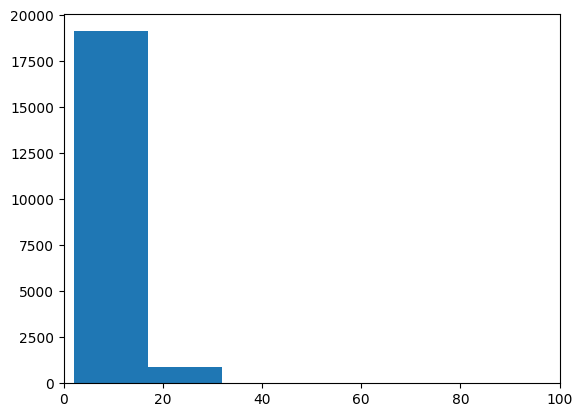

In [28]:
# Visualizing sentence length distribution
plt.hist([len(doc.split()) for doc in norm_train_texts], bins=10); # Generates a list containing the length (number of words) of each document in the norm_train_texts list.
plt.xlim([0, 100]) # Sets the x-axis limits to be between 0 and 100.

In [29]:
# Padding text sequences


MAX_SEQUENCE_LENGTH = 500

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((20033, 500), (8586, 500))

**Model 2: FastTest based Embedding Matrix**

In [30]:
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300
EPOCHS=100
BATCH_SIZE=128

In [31]:
# Download pre-trained FastText embeddings

!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip

--2024-01-19 14:22:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.70, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  78.9MB/s    in 6.2s    

2024-01-19 14:22:44 (104 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [32]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [33]:
# Generate pre-trained embedding matrix

word2idx = t.word_index
FASTTEXT_INIT_EMBEDDINGS_FILE = './wiki-news-300d-1M.vec'


def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):

    def get_coefs(word,*arr):
        return word, np.asarray(arr, dtype='float32')

    embeddings_index = dict(get_coefs(*row.split(" "))
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore')
                                    if len(row)>100)

    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))

    for word, idx in word_to_index.items():
        if idx >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [34]:
ft_embeddings = load_pretrained_embeddings(word_to_index=word2idx,
                                           max_features=VOCAB_SIZE,
                                           embedding_size=EMBED_SIZE,
                                           embedding_file_path=FASTTEXT_INIT_EMBEDDINGS_FILE)
ft_embeddings.shape

(22503, 300)

In [35]:
#Build model architecture

# create the model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          6750900   
                                                                 
 conv1d (Conv1D)             (None, 500, 256)          307456    
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 128)          131200    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 125, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 125, 64)           3

In [36]:
#Train model

model.fit(X_train, train_sarcasms,
          epochs=5,
          batch_size=BATCH_SIZE,
          shuffle=True,
          verbose=1)

Epoch 1/5
157/157 [==============================] - 29s 123ms/step - loss: 0.4672 - accuracy: 0.7470
Epoch 2/5
157/157 [==============================] - 7s 43ms/step - loss: 0.1930 - accuracy: 0.9261
Epoch 3/5
157/157 [==============================] - 6s 37ms/step - loss: 0.0654 - accuracy: 0.9780
Epoch 4/5
157/157 [==============================] - 5s 31ms/step - loss: 0.0229 - accuracy: 0.9926
Epoch 5/5
157/157 [==============================] - 4s 26ms/step - loss: 0.0106 - accuracy: 0.9969


In [37]:
#Model performance evaluation on the test dataset

predictions = model.predict(X_test, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(test_sarcasms, predictions)*100))
print(classification_report(test_sarcasms, predictions))
pd.DataFrame(confusion_matrix(test_sarcasms, predictions))

Accuracy: 85.92%
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4506
           1       0.83      0.89      0.86      4080

    accuracy                           0.86      8586
   macro avg       0.86      0.86      0.86      8586
weighted avg       0.86      0.86      0.86      8586



,0,1
0,3739,767
1,442,3638


In [38]:
del ft_embeddings
del model

In [39]:
import gc
gc.collect()

6041

**Model 3: Neural Network Language Model (NNLM)**

In [40]:
# Sample training data
norm_train_texts[:30]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep totally nails why congress is falling short on gender racial equality',
 'eat your veggies 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 'mother comes pretty close to using word streaming correctly',
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 'richard branson s global warming donation nearly as much as cost of failed balloon trips',
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario',
 'this lesbian is considered a father in indiana and an amazing one at that',
 'amanda peet told her daughter sex is a special hug',
 'what to know regarding current treatments for ebola',
 'chris christie suggests hillary clinton was to blame for boko haram s kidnapping of hundreds of schoolgirls',
 'ford develops new suv that runs purely on gasoline',
 'uber ceo travis kalanick stepping down

In [41]:
# Build a NNLM Embedding Layer

model = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model, output_shape=[128], input_shape=[],
                           dtype=tf.string, trainable=True)
print(hub_layer(np.array(norm_test_texts)[:3]))

tf.Tensor(
[[ 5.59501529e-01  1.86877653e-01 -5.30687571e-02 -4.35013212e-02
  -9.68373567e-02  2.47293890e-01  1.05083756e-01 -8.14772695e-02
  -1.19003654e-01  1.07220389e-01  2.75486838e-02 -5.98215982e-02
  -1.27855480e-01 -1.43972620e-01 -1.74296856e-01  2.76266262e-02
  -3.17286663e-02 -7.00699165e-03 -1.37605339e-01  1.00357495e-01
   5.21372445e-02  4.62679863e-02 -6.12243451e-02 -1.57725260e-01
  -1.08858757e-01 -5.70257120e-02  1.33517012e-01 -4.72868532e-02
   7.12604001e-02  1.64100584e-02  2.16040120e-01  1.02861799e-01
   9.05561671e-02 -1.96044501e-02  1.40286818e-01  4.98899110e-02
  -1.04842395e-01 -3.51987146e-02  4.27952893e-02  1.77116975e-01
  -1.00605510e-01 -5.15332744e-02 -8.90006796e-02  5.78188375e-02
   2.33075079e-02 -2.84995232e-02 -6.34935796e-02  8.32798108e-02
  -5.28905652e-02  1.56391617e-02  1.43108323e-01  6.70655668e-02
   1.55422255e-01  5.00761531e-02 -7.14281872e-02 -1.91334829e-01
   1.12082241e-02  2.47955732e-02  1.31007329e-01  1.75066128e-01

In [42]:
# Build model architecture

model = tf.keras.models.Sequential()

model.add(hub_layer)

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124675841 (475.60 MB)
Trainable params: 

In [43]:
# Train model

EPOCHS=5
BATCH_SIZE=128

model.fit(np.array(norm_train_texts), train_sarcasms,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          verbose=1)


Epoch 1/5
157/157 [==============================] - 12s 68ms/step - loss: 0.4326 - accuracy: 0.8021
Epoch 2/5
157/157 [==============================] - 5s 32ms/step - loss: 0.2147 - accuracy: 0.9189
Epoch 3/5
157/157 [==============================] - 5s 30ms/step - loss: 0.1125 - accuracy: 0.9608
Epoch 4/5
157/157 [==============================] - 3s 19ms/step - loss: 0.0610 - accuracy: 0.9794
Epoch 5/5
157/157 [==============================] - 3s 18ms/step - loss: 0.0282 - accuracy: 0.9909


In [44]:
# Model performance evaluation on the test dataset

predictions = model.predict(np.array(norm_test_texts), batch_size=512, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(test_sarcasms, predictions)*100))
print(classification_report(test_sarcasms, predictions))
pd.DataFrame(confusion_matrix(test_sarcasms, predictions))

Accuracy: 83.73%
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      4506
           1       0.83      0.83      0.83      4080

    accuracy                           0.84      8586
   macro avg       0.84      0.84      0.84      8586
weighted avg       0.84      0.84      0.84      8586



,0,1
0,3805,701
1,696,3384


In [45]:
del hub_layer
del model

**Model 4: Google's Universal Sentence Encoder**

In [46]:
norm_train_texts[:30]

['thirtysomething scientists unveil doomsday clock of hair loss',
 'dem rep totally nails why congress is falling short on gender racial equality',
 'eat your veggies 9 deliciously different recipes',
 'inclement weather prevents liar from getting to work',
 'mother comes pretty close to using word streaming correctly',
 'my white inheritance',
 '5 ways to file your taxes with less stress',
 'richard branson s global warming donation nearly as much as cost of failed balloon trips',
 'shadow government getting too large to meet in marriott conference room b',
 'lots of parents know this scenario',
 'this lesbian is considered a father in indiana and an amazing one at that',
 'amanda peet told her daughter sex is a special hug',
 'what to know regarding current treatments for ebola',
 'chris christie suggests hillary clinton was to blame for boko haram s kidnapping of hundreds of schoolgirls',
 'ford develops new suv that runs purely on gasoline',
 'uber ceo travis kalanick stepping down

In [47]:
# Load USE model TF Hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embed = hub.load(module_url)

In [48]:
# Sample vectorization of training headlines

message_embeddings = embed(norm_train_texts[:30])

message_embeddings, message_embeddings.shape

(<tf.Tensor: shape=(30, 512), dtype=float32, numpy=
 array([[ 0.00118074, -0.05161781, -0.01103917, ..., -0.02043086,
         -0.05175626, -0.05554493],
        [-0.02668647, -0.06806459,  0.06780286, ...,  0.04235078,
         -0.04038062,  0.0397289 ],
        [-0.07080504, -0.0666168 ,  0.05190708, ...,  0.06909546,
          0.04138178, -0.07180468],
        ...,
        [ 0.04641837, -0.07178034, -0.00530136, ..., -0.01855752,
          0.02993712,  0.05210235],
        [-0.01646928, -0.0524186 ,  0.05274916, ..., -0.03844151,
         -0.08222042, -0.01274051],
        [ 0.02704429, -0.0523579 , -0.01181477, ..., -0.00810924,
          0.04330008, -0.00672136]], dtype=float32)>,
 TensorShape([30, 512]))

In [49]:
# Build a USE embedding layer

model = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(model, output_shape=[512], input_shape=[],
                           dtype=tf.string, trainable=True)
print(hub_layer(np.array(norm_train_texts)[:30]))

tf.Tensor(
[[ 0.00118074 -0.05161781 -0.01103917 ... -0.02043085 -0.05175626
  -0.05554494]
 [-0.02668648 -0.06806457  0.06780286 ...  0.04235078 -0.04038061
   0.03972889]
 [-0.07080504 -0.0666168   0.05190708 ...  0.06909546  0.04138178
  -0.07180468]
 ...
 [ 0.04641837 -0.07178033 -0.00530136 ... -0.01855751  0.02993712
   0.05210235]
 [-0.01646928 -0.0524186   0.05274914 ... -0.03844152 -0.08222041
  -0.0127405 ]
 [ 0.02704429 -0.05235791 -0.01181478 ... -0.00810924  0.04330009
  -0.00672136]], shape=(30, 512), dtype=float32)


In [50]:
# Build model architecture

model = tf.keras.models.Sequential()

model.add(hub_layer)

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 256995201 (980.36 MB)
Trainable params: 

In [51]:
EPOCHS=5
BATCH_SIZE=128

# Fit the model

model.fit(np.array(norm_train_texts), train_sarcasms,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          verbose=1)

Epoch 1/5
157/157 [==============================] - 163s 845ms/step - loss: 0.4081 - accuracy: 0.8095
Epoch 2/5
157/157 [==============================] - 29s 186ms/step - loss: 0.1136 - accuracy: 0.9581
Epoch 3/5
157/157 [==============================] - 21s 134ms/step - loss: 0.0104 - accuracy: 0.9970
Epoch 4/5
157/157 [==============================] - 18s 117ms/step - loss: 0.0023 - accuracy: 0.9994
Epoch 5/5
157/157 [==============================] - 17s 106ms/step - loss: 3.9981e-04 - accuracy: 1.0000


In [52]:
# Model performance evaluation on the test dataset
predictions = model.predict(np.array(norm_test_texts), batch_size=512, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(test_sarcasms, predictions)*100))
print(classification_report(test_sarcasms, predictions))
pd.DataFrame(confusion_matrix(test_sarcasms, predictions))

Accuracy: 87.82%
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4506
           1       0.87      0.88      0.87      4080

    accuracy                           0.88      8586
   macro avg       0.88      0.88      0.88      8586
weighted avg       0.88      0.88      0.88      8586



,0,1
0,3965,541
1,505,3575


**Transformers**

In [53]:
#!nvidia-smi

In [54]:
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#import tensorflow as tf
#import tensorflow_hub as hub
#import transformers
#import tqdm
#from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

#%matplotlib inline

# fix random seed for reproducibility
#seed = 42
#np.random.seed(seed)
#tf.random.set_seed(seed)

In [55]:
#!pip install transformers

In [56]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("TF Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
TF Hub version:  0.15.0
GPU is available


In [57]:
#!gdown --id 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

In [58]:
# load and view dataset

#df = pd.read_json('./SarcasmDetect.json', lines=True)
#df.head()


In [59]:
#df.head()

In [60]:

#headlines = df['headline'].values
#sarcasms = df['is_sarcastic'].values

#train_headlines = headlines[:20033]
#test_headlines = headlines[20033:]


#train_sarcasms = sarcasms[:20033]
#test_sarcasms = sarcasms[20033:]

#train_headlines.shape, test_headlines.shape

**Model 5: BERT**


In [61]:
# BERT tokenization

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [62]:
# Data preparation

def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks, all_segments= [], [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        # with newer versions of transformers you don't need to explicitely add CLS and SEP
        # they are automatically added by the tokenizer
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids) # [1,1,1.....] # < 500 ones

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        segments = [0] * max_seq_length # [0,0,0...] # 500 zeros
        all_ids.append(ids)
        all_masks.append(masks)
        all_segments.append(segments)

    encoded = np.array([all_ids, all_masks, all_segments])

    return encoded

In [63]:
#Build model architecture

MAX_SEQ_LENGTH = 500

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inp_segment = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_segment_ids")
inputs = [inp_id, inp_mask, inp_segment]

hidden_state = transformers.TFBertModel.from_pretrained('bert-base-uncased')(inputs)
pooled_output = hidden_state[1]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 500)]                0         []                            
 er)                                                                                              
                                                                                                  
 bert_segment_ids (InputLay  [(None, 500)]                0         []                            
 er)                                                                                          

In [64]:
train_features_ids, train_features_masks, train_features_segments = create_bert_input_features(tokenizer,
                                                                                               train_headlines,
                                                                                               max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape, train_features_segments.shape)


Converting docs to features: 100%|██████████| 20033/20033 [00:09<00:00, 2021.31it/s]


Train Features: (20033, 500) (20033, 500) (20033, 500)


In [66]:
# Train model


model.fit([train_features_ids,
           train_features_masks,
           train_features_segments], train_sarcasms,
           epochs=3, # run more only if needed as this takes a long time
          batch_size=7, # reduce this in case you get GPU OOM error
          shuffle=True,
          verbose=1)



Epoch 1/3
2862/2862 [==============================] - 931s 316ms/step - loss: 0.2739 - accuracy: 0.8841
Epoch 2/3
2862/2862 [==============================] - 856s 299ms/step - loss: 0.1133 - accuracy: 0.9593
Epoch 3/3
2862/2862 [==============================] - 856s 299ms/step - loss: 0.0474 - accuracy: 0.9848


In [67]:
model.save_weights('bert_ft_wts.h5')

In [68]:
# convert test headlines to BERT input features
test_features_ids, test_features_masks, test_features_segments = create_bert_input_features(tokenizer,
                                                                                            test_headlines,
                                                                                            max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape, test_features_segments.shape)

Converting docs to features: 100%|██████████| 8586/8586 [00:03<00:00, 2264.18it/s]


Test Features: (8586, 500) (8586, 500) (8586, 500)


In [69]:
# Model performnce evaluation on the test dataset

predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks,
                                            test_features_segments], verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sarcasms, predictions)*100))
print(classification_report(test_sarcasms, predictions))
pd.DataFrame(confusion_matrix(test_sarcasms, predictions))

Accuracy: 92.67%
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      4506
           1       0.95      0.90      0.92      4080

    accuracy                           0.93      8586
   macro avg       0.93      0.93      0.93      8586
weighted avg       0.93      0.93      0.93      8586



,0,1
0,4300,206
1,423,3657


**Model 5: Distill BERT**

In [70]:
# BERT tokenization
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [71]:
def create_bert_input_features(tokenizer, docs, max_seq_length):

    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):

        tokens = tokenizer.tokenize(doc)

        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)

        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)

        all_ids.append(ids)
        all_masks.append(masks)

    encoded = np.array([all_ids, all_masks])

    return encoded

In [72]:
# Build model architecture

MAX_SEQ_LENGTH = 500

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)
dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)


model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5,
                                           epsilon=1e-08),
              loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 bert_input_ids (InputLayer  [(None, 500)]                0         []                            
 )                                                                                                
                                                                                                  
 bert_input_masks (InputLay  [(None, 500)]                0         []                            
 er)                                                                                              
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6636288   ['bert_input_ids[0][0]',      
 stilBertModel)              den_state=(None, 500, 768)   0          'bert_input_masks[0][0]

In [80]:
# convert distilBERT input features
train_features_ids, train_features_masks = create_bert_input_features(tokenizer, train_headlines,
                                                                      max_seq_length=MAX_SEQ_LENGTH)
#test_features = create_bert_input_features(tokenizer, test_reviews, max_seq_length=MAX_SEQ_LENGTH)
print('Train Features:', train_features_ids.shape, train_features_masks.shape)


Converting docs to features: 100%|██████████| 20033/20033 [00:36<00:00, 555.29it/s] 


Train Features: (20033, 500) (20033, 500)


In [74]:
# Train model

model.fit([train_features_ids,
           train_features_masks], train_sarcasms,
          epochs=3,
          batch_size=7,
          shuffle=True,
          verbose=1)

Epoch 1/3
2862/2862 [==============================] - 459s 152ms/step - loss: 0.2859 - accuracy: 0.8774
Epoch 2/3
2862/2862 [==============================] - 433s 151ms/step - loss: 0.1159 - accuracy: 0.9561
Epoch 3/3
2862/2862 [==============================] - 433s 151ms/step - loss: 0.0467 - accuracy: 0.9831


In [75]:
model.save_weights('distillbert_ft_wts.h5')

In [76]:
# convert test headlines to BERT input features
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, test_headlines,
                                                                    max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 8586/8586 [00:03<00:00, 2446.55it/s]


Test Features: (8586, 500) (8586, 500)


In [78]:
predictions = [1 if pr > 0.5 else 0
                   for pr in model.predict([test_features_ids,
                                            test_features_masks], batch_size=7, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(test_sarcasms, predictions)*100))
print(classification_report(test_sarcasms, predictions))
pd.DataFrame(confusion_matrix(test_sarcasms, predictions))

Accuracy: 92.41%
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      4506
           1       0.93      0.91      0.92      4080

    accuracy                           0.92      8586
   macro avg       0.92      0.92      0.92      8586
weighted avg       0.92      0.92      0.92      8586



,0,1
0,4209,297
1,355,3725
